In [1]:
import autograd.numpy as np

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook
%matplotlib inline
# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
import matplotlib.pyplot as plt
from autograd import grad
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

from numpy.fft import *
import matplotlib.style as style 
style.use('ggplot')

# import function flattening module from autograd
from autograd.misc.flatten import flatten_func

In [3]:
Y = np.loadtxt('../data/test.csv',delimiter = ' ')[0]
# X = np.loadtxt('test.csv',delimiter = ' ')[1][:20000]
X = [i for i in range(len(Y))]

In [4]:
data = Y.copy()

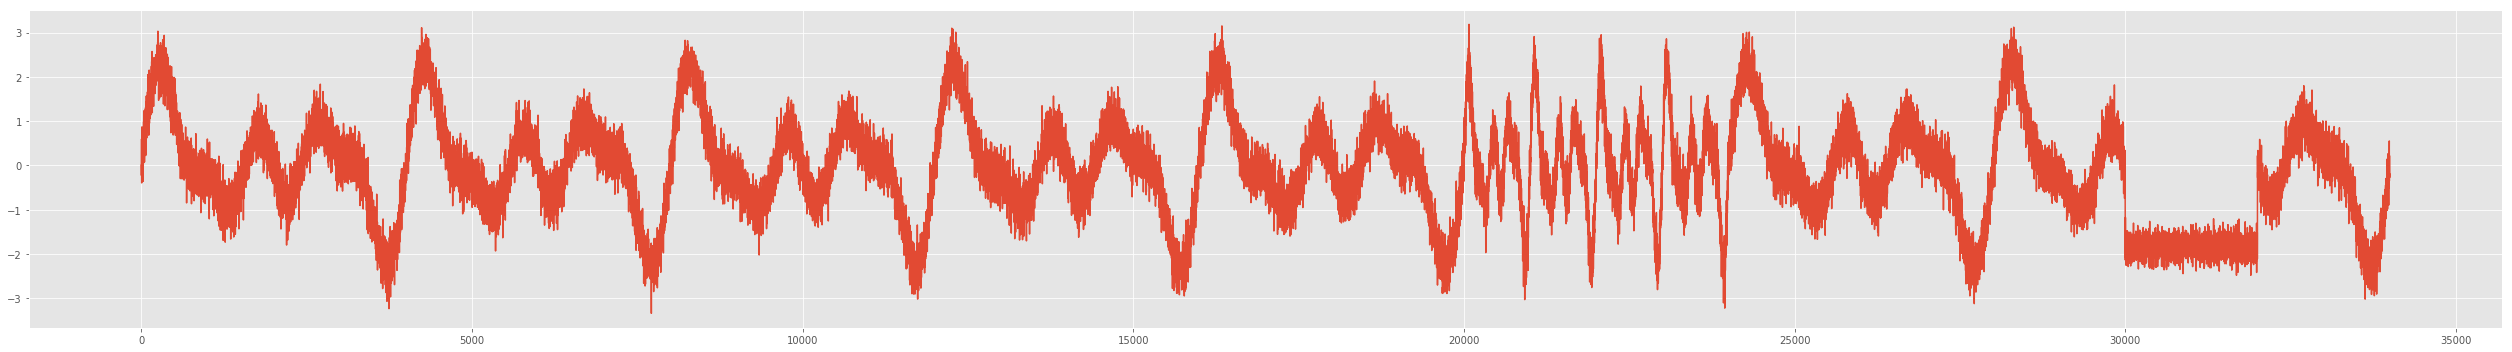

In [5]:
#Plot of all the data
plt.figure(figsize=(35,5))
plt.plot(data)
plt.show()

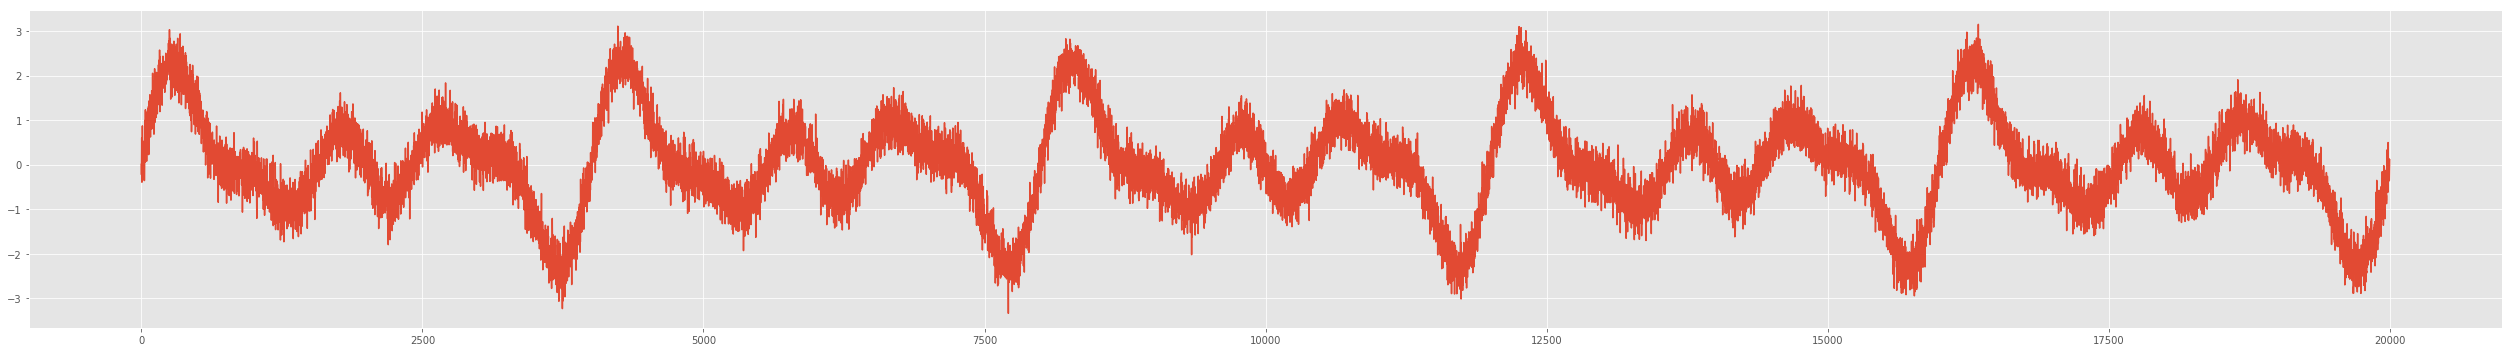

In [6]:
#Plot of a clean window of data
clean_data = data[:20000]
plt.figure(figsize=(35,5))
plt.plot(clean_data)
plt.show()

In [7]:
def filter_signal(signal, threshold=5e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [8]:
denoised_data = filter_signal(clean_data)

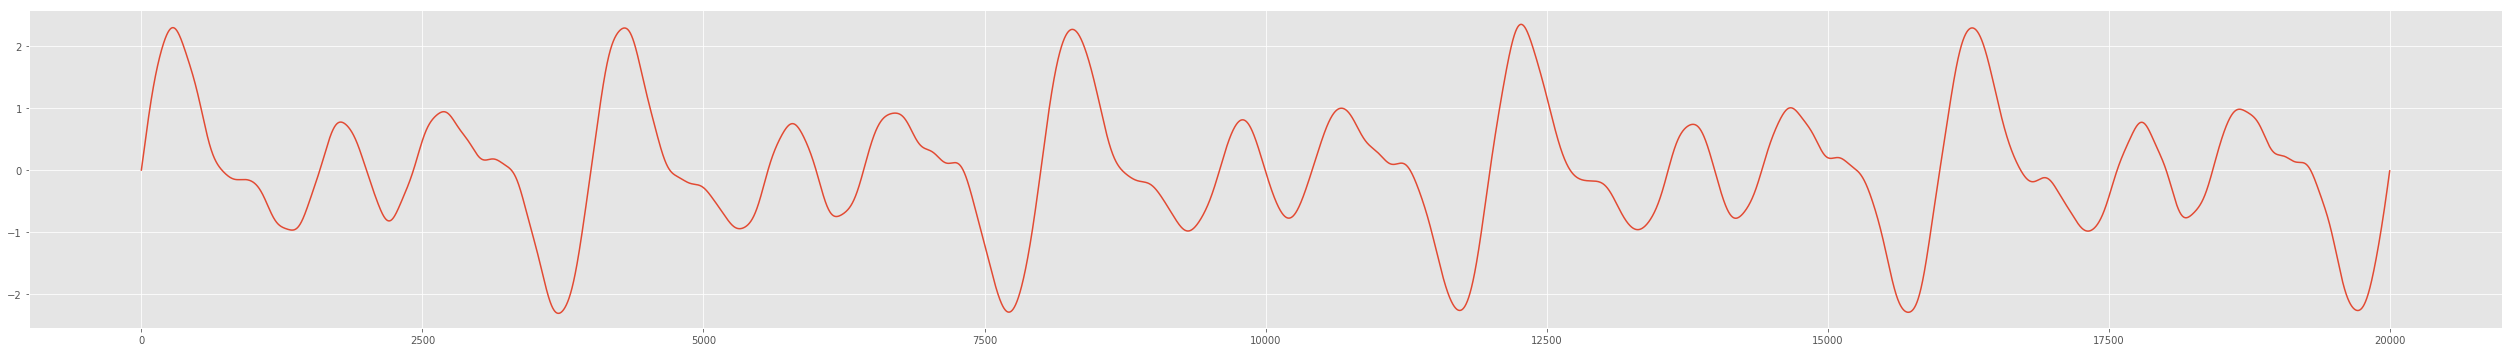

In [9]:
# Plot cleaned data by filtering out all frequencies greater than the threshold
plt.figure(figsize=(35,5))
plt.plot(denoised_data)
plt.show()

In [10]:
#Frequency analysis of the denoised data
from scipy import fftpack
X = fftpack.fft(denoised_data)
freqs = fftpack.fftfreq(len(denoised_data)) 

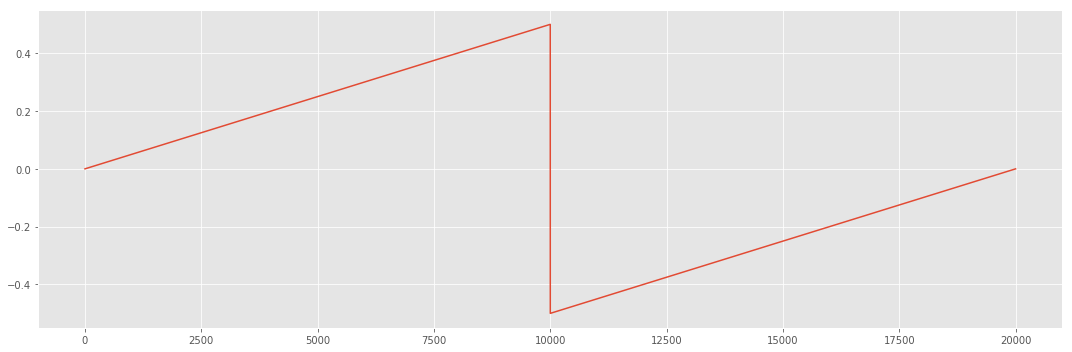

In [11]:
plt.figure(figsize=(15,5))
plt.plot(freqs)
plt.show()

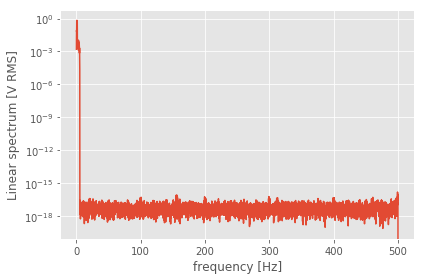

In [12]:
from scipy.signal import periodogram
f, Pxx_spec = periodogram(denoised_data, 1e3, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

In [13]:
# load in cruise control data
data = np.loadtxt('../data/test.csv',delimiter = ' ')

# extract actions and states 
states = denoised_data[np.newaxis,:] # our T states
actions = data[1,1:20000][np.newaxis,:] # our T-1 actions  

print(actions.shape,states.shape)

(1, 19999) (1, 20000)


In [14]:
# denoised_data = denoised_data[np.newaxis,:]

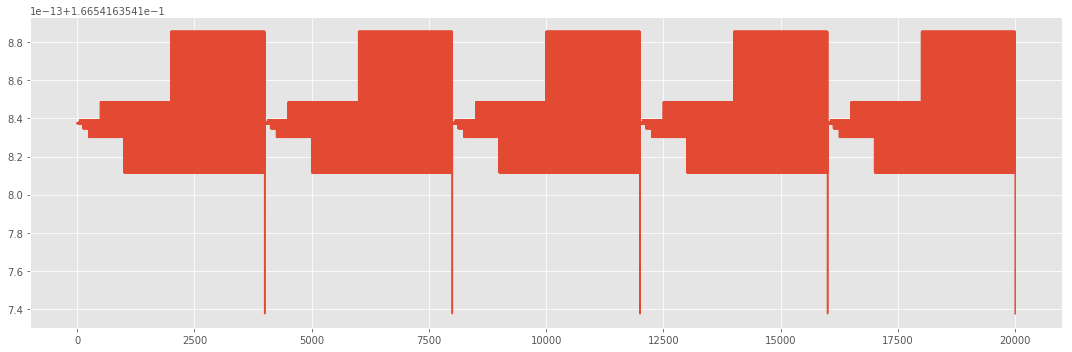

In [15]:
plt.figure(figsize=(15,5))
plt.plot(actions[0])
plt.show()

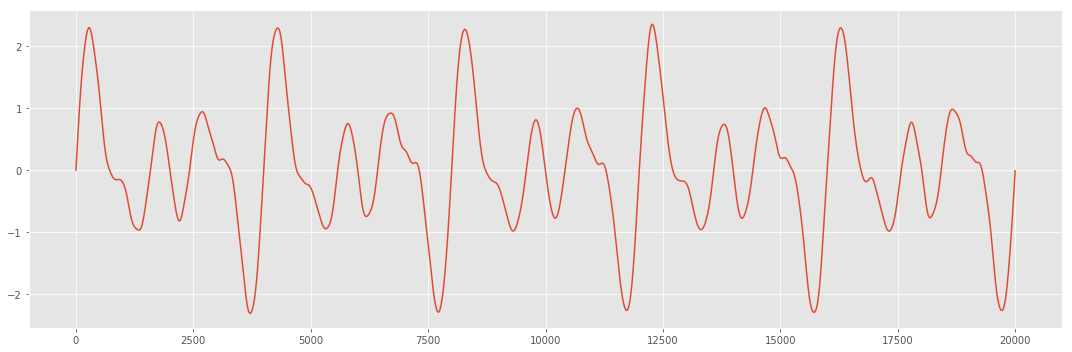

In [16]:
plt.figure(figsize=(15,5))
plt.plot(states[0])
plt.show()

In [17]:
# A simple (order 1 MDP, linear) system model implementation
def system_model(s_t,a_t,w):
    return w[0] + w[1]*s_t + w[2]*a_t

# loop for evaluating system_model over all input/output action/state pairs
def system_loop(w,a,s):
    # compute least squares over all system model outputs at once
    s_predict = [s[:,0]]  # container for system_model state outputs
    for t in range(a.shape[1]):
        # get current action-state pair
        a_t = a[:,t]
        s_t = s[:,t]
        
        # feed into system_model to get predicted output
        s_hat = system_model(s_t,a_t,w)
        
        # store prediction
        s_predict.append(s_hat)
        
    # array-afy predictions and return
    return np.array(s_predict).T

# an implementation of the least squares cost for system identification
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(w,a,s):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    s_predict = system_loop(w,a,s)

    # compute least squares error between real and predicted states
    cost = np.sum((s_predict[:,1:] - s[:,1:])**2)
    return cost/float(s.shape[1]-1)


def gradient_descent(g,alpha,max_its,w): 
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
#    cost_history = [g(w)] # cost function history container
    cost_history = [g(w,actions,states)]
    for k in range(max_its):
        # evaluate the gradient
        #grad_eval = gradient(w)
        grad_eval = gradient(w,actions,states)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
#        cost_history.append(g(w))
        cost_history.append(g(w,actions,states))
    return weight_history,cost_history

In [18]:
# zero order coordinate search
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the dirction matrix out of the loop
        DIRECTION = np.eye(N)
        cost = g(w, actions, states)
#         cost = g(w)
        
        # loop over each coordinate direction
        for n in range(N):
            #direction = np.zeros((N,1))
            #direction[c[n]] = 1
            direction = DIRECTION[:,[c[n]]]
     
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction,actions,states)]
            evals.append(g(w - alpha*direction,actions,states))
#             evals =  [g(w + alpha*direction)]
#             evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w, actions, states))
#     cost_history.append(g(w))
    return weight_history,cost_history

In [19]:
# g=least_squares;
# w = 0.1*np.random.randn(3,1);
# k=150; alph = .0001;
# weight_history_1,cost_history_1 = gradient_descent(g,alph,k,w)

g=least_squares;
w = 0.1*np.random.randn(3,1);

# flatten an input function g
#g, unflatten_func, w = flatten_func(g, w)

# k=300; alph = .0001;
k=50; alph = 'diminishing';
# weight_history_1,cost_history_1 = gradient_descent(g,alph,k,w)
weight_history_1,cost_history_1 = coordinate_descent_zero_order(g,alph,k,w)

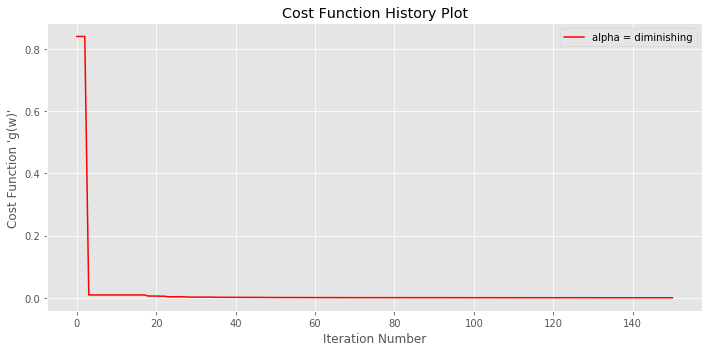

In [20]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(len(cost_history_1)),cost_history_1,c='red',label='alpha = '+str(alph))
plt.legend(loc='upper right')
plt.title("Cost Function History Plot")
plt.xlabel("Iteration Number")
plt.ylabel("Cost Function 'g(w)'")
plt.show()

In [53]:
# np.rand.randn(max(actions[0]), min(actions[0]))

ran_floats = [random.uniform(min(actions[0]),10*max(actions[0])) for _ in range(len(actions[0]))]

In [54]:
ran_floats = np.asarray(ran_floats)

In [55]:
actions[0]

array([0.16654164, 0.16654164, 0.16654164, ..., 0.16654164, 0.16654164,
       0.16654164])

In [56]:
# temp = actions[0]+np.asarray(ran_floats)
temp = np.concatenate([actions[0],ran_floats])

In [57]:
# type(np.asarray(ran_floats)),type(actions[0])
len(temp)

39998

In [58]:
#generate prediction line
bestw=weight_history_1[-1]
print(bestw)
line1 = [system_model(s,a,bestw) for s,a in zip(states[0],temp)]

[[ 0.01440316]
 [ 0.99019075]
 [-0.09663031]]


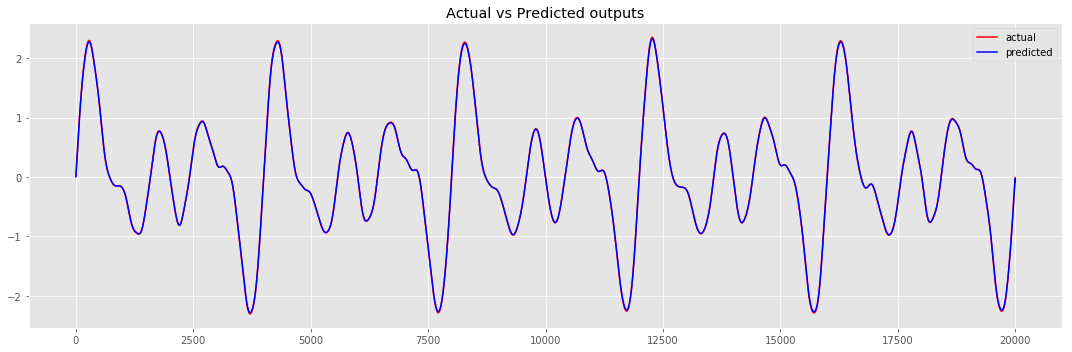

In [59]:
fig = plt.figure(figsize=(15,5))

plt.plot(range(len(states[0])-1),states[0][1:],c='red',label='actual')
plt.plot(range(len(line1)),line1,c='blue',label='predicted')

plt.legend(loc='upper right')
plt.title("Actual vs Predicted outputs")
plt.show()

In [60]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, arange, signal
plt.style.use('seaborn-poster')
%matplotlib inline

In [64]:
type(denoised_data)

numpy.ndarray

In [65]:
tempC = denoised_data

# we remove the mean of the signal to create a signal oscillating around 0
tempNorm = tempC - np.mean(tempC)

In [110]:
#sampling rate
fs = 2*24

# create timestamp that start with 1, this is means
t = arange(len(tempC))/float(fs) + 1

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


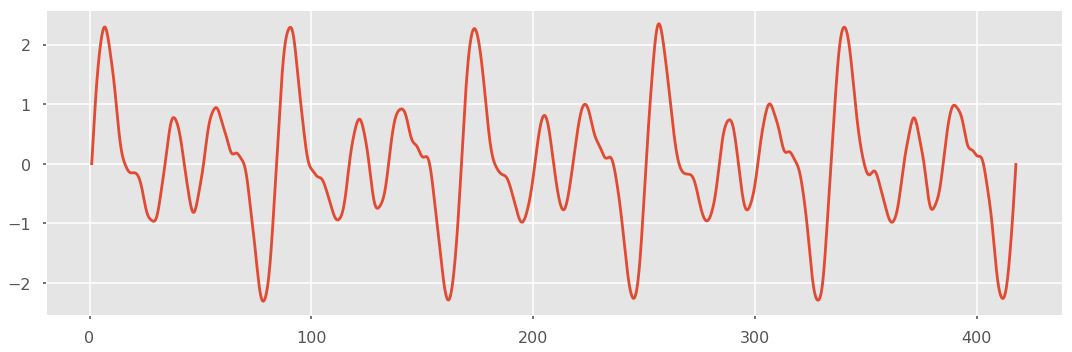

In [111]:
plt.figure(figsize = (15, 5))
plt.plot(t, tempNorm)

15.74074074074074

In [112]:
from matplotlib.mlab import find
def freq_zero_crossing(sig, fs):
    """
    Frequency estimation from zero crossing method
    sig - input signal
    fs - sampling rate
    
    return: 
    dominant period
    """
    # Find the indices where there's a crossing
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))

    # Let's calculate the real crossings by interpolate
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    
    # Let's get the time between each crossing
    # the diff function will get how many samples between each crossing
    # we divide the sampling rate to get the time between them
    delta_t = np.diff(crossings) / fs
    
    # Get the mean value for the period
    period = np.mean(delta_t)
    
    return period

In [117]:
period_from_zero_crossing = freq_zero_crossing(tempNorm, fs)
print('The period estimation is %.1f x-axis units'%(period_from_zero_crossing))

The period estimation is 27.0 x-axis units


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  if sys.path[0] == '':


In [114]:
# get the frequency and spectrum
f, Pxx = signal.periodogram(tempNorm, fs = fs, window='hanning', scaling='spectrum')

Text(0, 0.5, 'Spectrum Amplitude')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


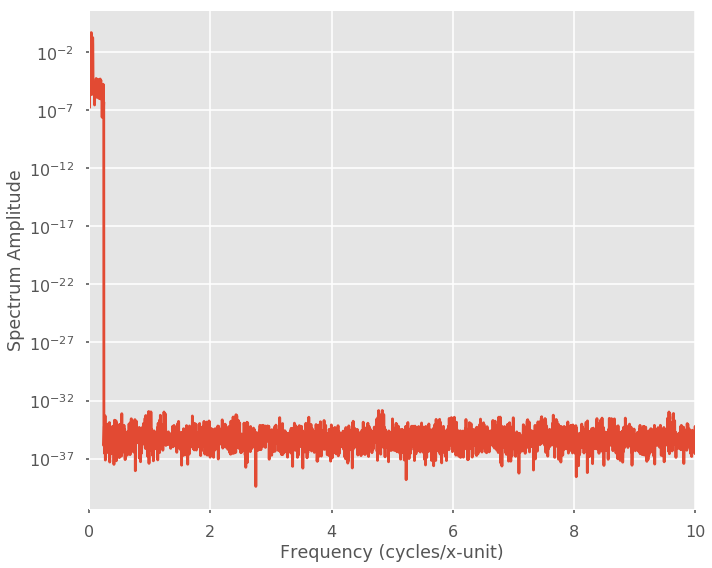

In [115]:
plt.figure(figsize = (10, 8))
plt.plot(f, Pxx)
plt.xlim(0, 10)
plt.yscale('log')
plt.xlabel('Frequency (cycles/x-unit)')
plt.ylabel('Spectrum Amplitude')

In [116]:
# print the top 6 period in the signal
for amp_arg in np.argsort(np.abs(Pxx))[::-1][1:6]:
    day = 1 / f[amp_arg]
    print(day)

41.666666666666664
16.666666666666664
26.041666666666664
29.76190476190476
37.878787878787875


Text(0, 0.5, 'Autocorrelation')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


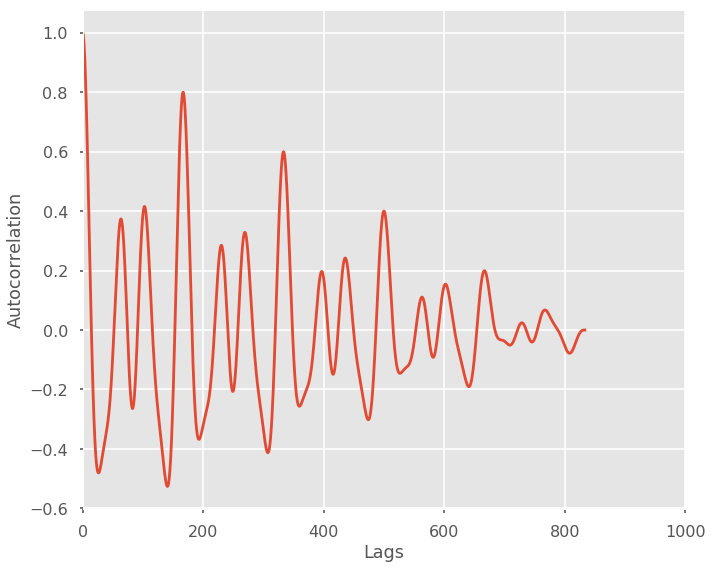

In [119]:
from statsmodels import api as sm
# get the autocorrelation coefficient
acf = sm.tsa.acf(tempNorm, nlags=len(tempNorm))
plt.figure(figsize = (10, 8))
lag = arange(len(tempNorm))/24.
plt.plot(lag, acf)
plt.xlim((0, 1000))
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

In [155]:
from scipy.signal import find_peaks


[ 1526  2463  4000  5524  6460  8000  9521 10457 11999 13514 14450 16001
 17492 18410]


Text(0, 0.5, 'Autocorrelation')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


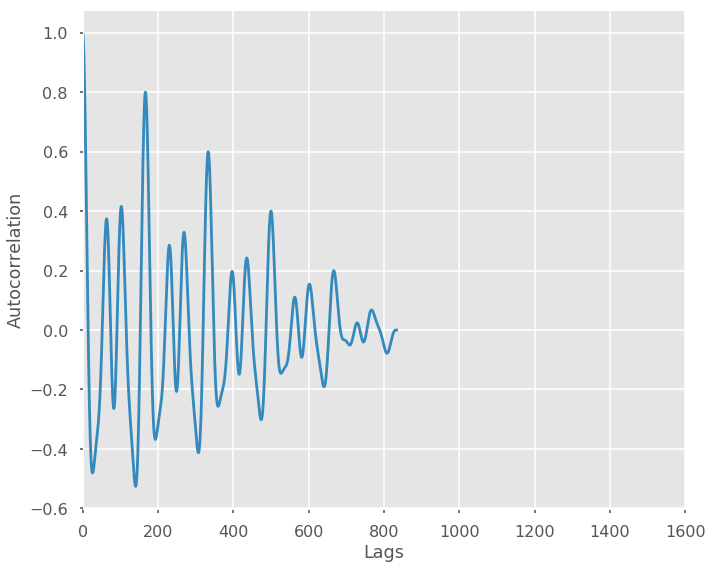

In [157]:
plt.figure(figsize = (10, 8))

peaks, _ = find_peaks(acf, height=(-1,1.2))
print(peaks)
# plt.plot(x)
plt.plot(peaks, acf[peaks], "x")
# plt.plot(np.zeros_like(x), "--", color="gray")

plt.plot(lag, acf)
plt.xlim((0, 1600))
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

In [170]:
peaks[2]

4000

In [171]:
np.diff(peaks)

array([ 937, 1537, 1524,  936, 1540, 1521,  936, 1542, 1515,  936, 1551,
       1491,  918])

In [172]:
acf[peaks]

array([0.373487  , 0.41545944, 0.79969734, 0.28484985, 0.3284968 ,
       0.59930188, 0.19694179, 0.24206235, 0.39985252, 0.11057907,
       0.1542169 , 0.19941758, 0.02435432, 0.06728748])

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


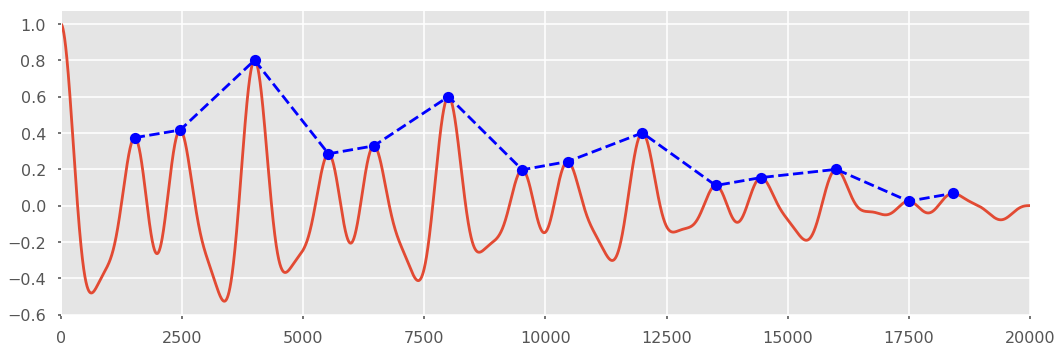

In [178]:
plt.figure(figsize=(15,5))
plt.plot(acf)
plt.plot(peaks, acf[peaks],'--bo')
plt.xlim((-1,20000))
plt.show()

In [181]:
np.argmax(acf[peaks])

2

In [126]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


AttributeError: 'numpy.ndarray' object has no attribute 'autocorr'

/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


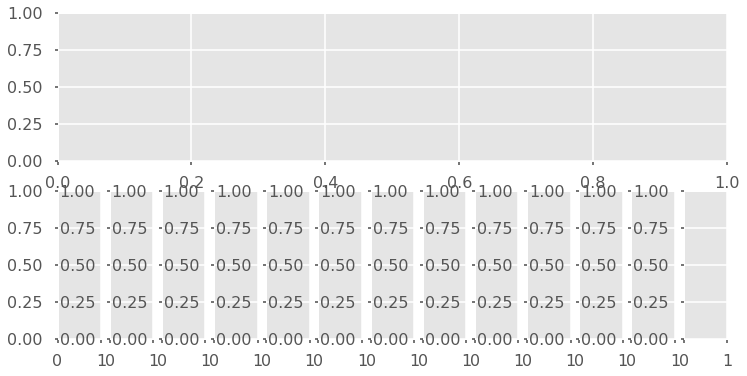

In [127]:
#%% show autocorr and lag plots
selectedLagPoints = [1,3,6,9,12,24,36,48,60,70,75,80,85]
maxLagDays = 200

originalSignal = denoised_data

# set grid spec of the subplots
plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, len(selectedLagPoints))
axTopRow = plt.subplot(gs[0, :])
axBottomRow = []
for i in range(len(selectedLagPoints)):
    axBottomRow.append(plt.subplot(gs[1, i]))

# plot autocorr
allTimeLags = np.arange(1,maxLagDays*24)
autoCorr = [originalSignal.autocorr(lag=dt) for dt in allTimeLags]
axTopRow.plot(allTimeLags,autoCorr); 
axTopRow.set_title('Autocorrelation Plot of Temperature Signal', fontsize=18);
axTopRow.set_xlabel('time lag [hours]'); axTopRow.set_ylabel('correlation coefficient')
selectedAutoCorr = [originalSignal.autocorr(lag=dt) for dt in selectedLagPoints]
axTopRow.scatter(x=selectedLagPoints, y=selectedAutoCorr, s=50, c='r')

# plot scatter plot of selected points
for i in range(len(selectedLagPoints)):
    lag_plot(originalSignal, lag=selectedLagPoints[i], s=0.5, alpha=0.7, ax=axBottomRow[i])    
    if i >= 1:
        axBottomRow[i].set_yticks([],[])
plt.tight_layout()